In [7]:
#导入必要依赖库
import torch.optim
import  torchvision
from torch.nn import Linear, Flatten, MaxPool2d, Conv2d
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import  nn
from torch.utils.tensorboard import SummaryWriter
import os
import pandas as pd
from PIL import Image
import torch.nn.init as init
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [8]:


class DAN(nn.Module):
    def __init__(self, num_class=7,num_head=4, pretrained=True):
        super(DAN, self).__init__()
        
        resnet = torchvision.models.resnet18(pretrained=True)
        
       # if pretrained:
           # checkpoint = torch.load('./models/resnet18_msceleb.pth')
            #resnet.load_state_dict(checkpoint['state_dict'],strict=True)

        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.num_head = num_head
        for i in range(num_head):
            setattr(self,"cat_head%d" %i, CrossAttentionHead())
        self.sig = nn.Sigmoid()
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)


    def forward(self, x):
        x = self.features(x)
        heads = []
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        
        heads = torch.stack(heads).permute([1,0,2])
        if heads.size(1)>1:
            heads = F.log_softmax(heads,dim=1)
            
        out = self.fc(heads.sum(dim=1))
        out = self.bn(out)
   
        return out, x, heads

class CrossAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = SpatialAttention()
        self.ca = ChannelAttention()
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        sa = self.sa(x)
        ca = self.ca(sa)

        return ca


class SpatialAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
        )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
        )
        self.conv_1x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(512),
        )
        self.conv_3x1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,1),padding=(1,0)),
            nn.BatchNorm2d(512),
        )
        self.relu = nn.ReLU()


    def forward(self, x):
        y = self.conv1x1(x)
        y = self.relu(self.conv_3x3(y) + self.conv_1x3(y) + self.conv_3x1(y))
        y = y.sum(dim=1,keepdim=True) 
        out = x*y
        
        return out 

class ChannelAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )


    def forward(self, sa):
        sa = self.gap(sa)
        sa = sa.view(sa.size(0),-1)
        y = self.attention(sa)
        out = sa * y
        
        return out




In [9]:
# 文件夹准备
# 拼接模型保存路径
folder_path = "../models/DAN_parm"

Train_data_path = '../RAF/images/train'
test_data_path = "../RAF/images/test"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)  

In [10]:

###准备数据集和测试集
###Tensor 形状： torch.Size([3, 100, 100]) 图像模式： RGB
transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize((48,48)),          #统一尺寸
    torchvision.transforms.ToTensor(),                   # 转换为 [C, H, W] 的张量，范围 [0, 1]
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])  
])
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),       # 水平翻转
    torchvision.transforms.RandomRotation(10),                # 旋转 ±10°
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 颜色抖动
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [11]:

loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
loss_function=loss_function.cuda()

torch.cuda.empty_cache()## 训练之前清理显存避免显存爆炸

lr_values = [1e-3, 1e-4, 1e-5]
batch_size_values = [32,64, 128, 256]
epochs_values = [15, 25, 30]
weight_decay_values= [ 1e-4, 1e-5,1e-6]
best_acc_values_in_each=[]

results = []


开始训练：lr=0.001, weight_decay=0.0001,batch_size=32, epochs=15
---------第1轮训练开始---------
训练次数100，Loss：1.5532945394515991
训练次数200，Loss：1.5171103477478027
训练次数300，Loss：1.2908085584640503
正确率0.6424380704041721
整体测试集上的Loss123.85991644859314
---------第2轮训练开始---------
训练次数400，Loss：1.185868501663208
训练次数500，Loss：1.3514845371246338
训练次数600，Loss：1.3834019899368286
训练次数700，Loss：1.2596899271011353
正确率0.6985006518904824
整体测试集上的Loss106.67274582386017
---------第3轮训练开始---------
训练次数800，Loss：1.2992448806762695
训练次数900，Loss：1.256252646446228
训练次数1000，Loss：1.1051409244537354
训练次数1100，Loss：1.404111623764038
正确率0.7105606258148631
整体测试集上的Loss100.41809767484665
---------第4轮训练开始---------
训练次数1200，Loss：1.0593780279159546
训练次数1300，Loss：1.159393072128296
训练次数1400，Loss：1.2091090679168701
训练次数1500，Loss：1.0851222276687622
正确率0.7086049543676662
整体测试集上的Loss101.03088748455048
---------第5轮训练开始---------
训练次数1600，Loss：1.30386221408844
训练次数1700，Loss：1.09651780128479
训练次数1800，Loss：0.962108850479126
训练次数1900，Loss：0.9639028310

KeyboardInterrupt: 

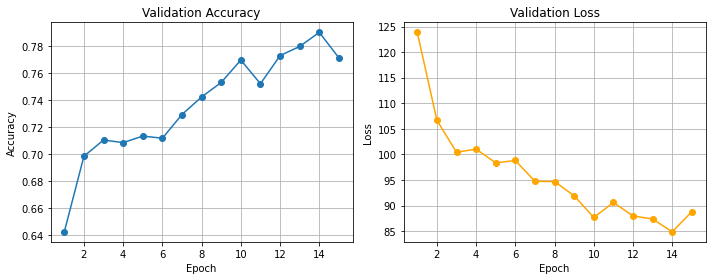

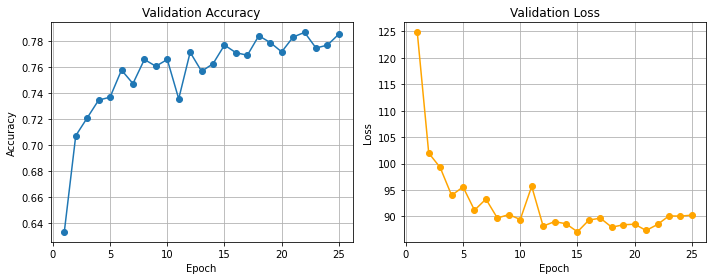

In [ ]:

for lr in lr_values:
    for weight_decay in weight_decay_values:
        for batch_size in batch_size_values:
            for epochs in epochs_values:

                total_train_step = 0
                
                model = DAN(num_class=7, pretrained=True)
                model.cuda()
                best_acc = 0

                accuracies=[]
                losses = []

                train_data = torchvision.datasets.ImageFolder(root=Train_data_path, transform=train_transform)
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)

                test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
                test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,drop_last=True)

                optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

                train_data_len = len(train_data)
                test_data_len = len(test_data)

                print(f"开始训练：lr={lr}, weight_decay={weight_decay},batch_size={batch_size}, epochs={epochs}")

                for i in range(epochs):
                    print("---------第{}轮训练开始---------".format(i+1))
                    model.train()
                    for data in train_loader:
                        img,target = data
                        img= img.cuda()
                        target = target.cuda()
                        output,x,heads = model(img)

                        loss=loss_function(output,target)
                        optimizer.zero_grad()

                        loss.backward()
                        optimizer.step()
                        
                        total_train_step+=1

                        if total_train_step % 100==0:
                            print("训练次数{}，Loss：{}".format(total_train_step,loss.item()))
                    #测试步骤
                    total_test_loss = 0
                    total_accuracy = 0
                    with torch.no_grad():
                        model.eval()
                        for data in test_loader :
                            img,target = data
                            img = img.cuda()
                            target = target.cuda()
                            output,x,heads = model(img)
                            loss = loss_function(output,target)
                            total_test_loss+=loss.item()
                            accuracy = (output.argmax(1) == target ).sum().item()
                            total_accuracy += accuracy
                    if(total_accuracy/test_data_len>best_acc):
                        best_acc = total_accuracy/test_data_len
                    print("正确率{}".format(total_accuracy/test_data_len))
                    accuracies.append(total_accuracy/test_data_len)
                    print("整体测试集上的Loss{}".format(total_test_loss))
                    losses.append(total_test_loss)
                
                best_acc_values_in_each.append(best_acc)
                results.append({
                    'Learning Rate': lr,
                    'Weight Decay': weight_decay,
                    'Batch Size': batch_size,
                    'Epochs': epochs,
                    'Best Accuracy': best_acc
                })

                #画图并保存
                epochs = list(range(1, len(accuracies)+1))

                plt.figure(figsize=(10, 4))

                plt.subplot(1, 2, 1)
                plt.plot(epochs, accuracies, label='Accuracy', marker='o')
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")
                plt.title("Validation Accuracy")
                plt.grid(True)

                plt.subplot(1, 2, 2)
                plt.plot(epochs, losses, label='Test Loss', color='orange', marker='o')
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.title("Validation Loss")
                plt.grid(True)

                plt.tight_layout()

                save_path = os.path.join(folder_path, 
                                         f"accuracy_and_loss_lr_{lr}_wd_{weight_decay}_bs_{batch_size}_epochs_{epochs[[-1]}.png")
                plt.savefig(save_path)
                                
                print(f"图像已保存到: {save_path}")


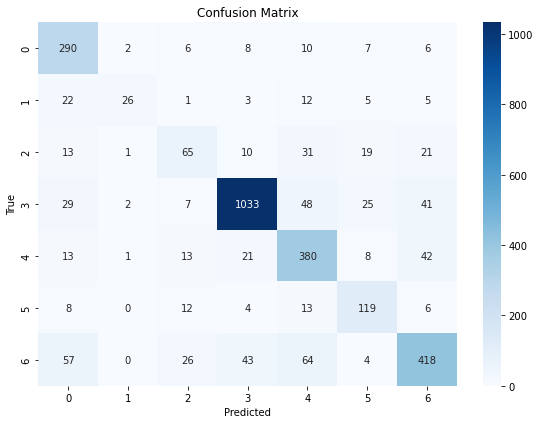

In [ ]:
df = pd.DataFrame(results)

# 保存路径
file_path = "../hyperparameter_results_dan.xlsx"
df.to_excel(file_path, index=False)